In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import jieba

In [19]:
df_cs = pd.read_excel('消费数据.xlsx')
df_post = pd.read_excel('发帖数据.xlsx')
df_action = pd.read_excel('活动数据.xlsx')

In [251]:
activity_date = df_action['活动时间'][0]
cost = df_action['活动成本'][0]
moving_threshold = df_action['活动门槛'][0]

In [202]:
# 活动效果分析 使用用户的首次发贴时间，最后发帖时间，发帖总数，活动的奖励门槛，活动奖励总价值，五个字段综合分析；
# 用户发帖数据
df_post_temp = df_post.loc[:,['发布时间','UID']]
df_post_temp['发布时间'] = pd.to_datetime(df_post_temp['发布时间']).dt.floor('d')
df_post_temp['首次发帖时间'] = df_post_temp.groupby('UID')['发布时间'].transform('min')
df_post_temp['用户总发帖量'] = df_post_temp.groupby('UID')['发布时间'].transform('count')
df_post_temp['日发帖量'] = df_post_temp.groupby(['UID','发布时间'])['发布时间'].transform('count')
df_post_temp['最后发帖时间'] = df_post_temp.groupby('UID')['发布时间'].transform('max')

df_post_temp_a = df_post_temp[df_post_temp['发布时间']>= activity_date].copy() # 选取活动开始之后的数据
df_post_temp_a['用户活动发贴量'] = df_post_temp_a.groupby('UID')['发布时间'].transform('count')
df_post_temp_a['累计发布数'] = df_post_temp_a.groupby('UID')['日发帖量'].cumsum()

df_post_res = pd.merge(df_post_temp,df_post_temp_a,on=['发布时间','UID','首次发帖时间','用户总发帖量','日发帖量'])
df_post_res.columns

Index(['发布时间', 'UID', '首次发帖时间', '用户总发帖量', '日发帖量', '最后发帖时间_x', '最后发帖时间_y',
       '用户活动发贴量', '累计发布数'],
      dtype='object')

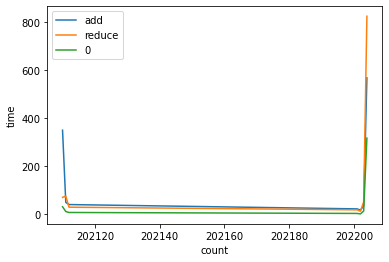

In [250]:
# 平台用户注册情况和流失情况
# 因无法获取最后登录时间，所以暂以用户不再发布时间为流失用户,同理,新增用户的统计口径为第一次发布帖子的时间.
df_post_temp1 = df_post_temp.loc[:,['发布时间','最后发帖时间','首次发帖时间','UID']]
df_post_temp1['发布时间'] = pd.to_datetime(df_post_temp1['发布时间'])
df_post_temp1['年'] = df_post_temp1['发布时间'].dt.year
df_post_temp1['月'] = df_post_temp1['发布时间'].dt.month


# 新增数据统计
df_post_a = df_post_temp1.loc[:,['首次发帖时间','UID','年','月']]
df_post_a['年'] = df_post_temp1['首次发帖时间'].dt.year
df_post_a['月'] = df_post_temp1['首次发帖时间'].dt.month
df_post_a = df_post_a.drop_duplicates(subset=['首次发帖时间','UID'],keep='first')

df_group_a = df_post_a.groupby(['年','月'])['首次发帖时间'].count().rename('新增')

# 流失数据统计
df_post_m = df_post_temp1.loc[:,['最后发帖时间','UID','年','月']] 
df_post_m['年'] = df_post_m['最后发帖时间'].dt.year
df_post_m['月'] = df_post_m['最后发帖时间'].dt.month
df_post_m = df_post_m.drop_duplicates(subset=['最后发帖时间','UID'],keep='first')
df_group_m = df_post_m.groupby(['年','月'])['最后发帖时间'].count().rename('流失')

# 注册和消失同一天用户统计
df_post_o = df_post_temp1[df_post_temp1['最后发帖时间'] == df_post_temp1['首次发帖时间']]
df_post_o = df_post_.drop_duplicates(subset=['UID'],keep='first')
df_group_o = df_post_o.groupby(['年','月'])['UID'].count().rename('新增流失同一天')

df_res = pd.concat([df_group_a,df_group_m,df_group_o],axis = 1)

time = [202110,202111,202112,202201,202202,202203,202204]
y1 = list(df_res['新增'])
y2 = list(df_res['流失'])
y3 = list(df_res['新增流失同一天'])

plt.plot(time, y1, label='add')
plt.plot(time, y2, label='reduce')
plt.plot(time, y3, label='0') # 新增流失同一天

plt.legend()
plt.xlabel('count')
plt.ylabel('time')

plt.show()

{'total': 668,
 'moving_threshold': 338,
 'moving_threshold*1.5': 118,
 'moving_threshold*2': 45}

C:\Users\31007\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21457 (\N{CJK UNIFIED IDEOGRAPH-53D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\31007\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24086 (\N{CJK UNIFIED IDEOGRAPH-5E16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\31007\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\31007\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\31007\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_

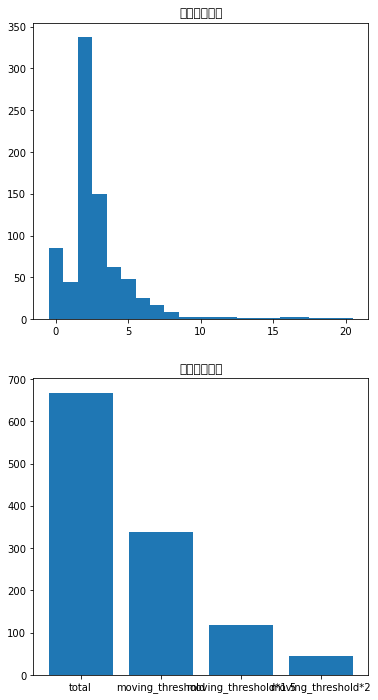

In [252]:
# 奖励与用户行为的关系分析

dic = {} # 活动数据统计
# 奖励门槛人数统计
a = df_post_res.loc[df_post_res['用户活动发贴量'] >= moving_threshold].groupby('UID')['用户总发帖量'].unique()

# 发帖数分布统计
b = df_post_res.groupby('用户活动发贴量')['UID'].unique()
b = [(k,len(i)) for k,i in enumerate(b)]

x = [i[0] for i in b]
y = [i[1] for i in b]
fig, axs = plt.subplots(2, 1, figsize=(6, 12)) 

axs[0].bar(x,y,1)
axs[0].set_title('发帖人数分布')

# 在到达门槛后的用户发帖分布情况
dic['total'] = a.size # 奖励需发放人数
dic['moving_threshold'] = max(y) # 刚好达到门槛人数
dic['moving_threshold*1.5'] = sum([i for k,i in b if k > moving_threshold * 1.5 ]) # 发帖超门槛数1.5倍的人数
dic['moving_threshold*2'] = sum([i for k,i in b if k > moving_threshold * 2 ]) # 发帖超门槛数2倍的人数

hight_values_use = sum([i for k,i in b if k > moving_threshold * 3 ]) # 发帖量超过门槛三倍的，可以视作高活跃用户，并非单纯冲着奖励来的。

x1 = dic.keys()
y1 = dic.values()

axs[1].bar(x1,y1)
axs[1].set_title('奖励人数分布')
dic

In [264]:
# 活动成本评估
# 单个用户成本dic['单个用户成本']
dic['单个用户成本'] = format(cost / dic['total'],'.2f')

# 单篇帖子成本
dic['单篇帖子成本'] = format(cost / df_post_temp_a['用户活动发贴量'].sum(),'.2f')

dic

{'total': 668,
 'moving_threshold': 338,
 'moving_threshold*1.5': 118,
 'moving_threshold*2': 45,
 '单个用户成本': '598.80',
 '单篇帖子成本': '19.87'}

In [282]:
# 订单分析,消费用户分层
to_day = pd.to_datetime( '2022-04-28')
a = df_cs.groupby(['收货手机号'])
col1 = df_cs.groupby(['收货手机号'])['总价'].sum().astype('float64').rename('M')
col2 = df_cs.groupby(['收货手机号'])['创建时间'].apply(lambda x:(to_day - max(x)).days).rename('R')
col3 = df_cs.groupby(['收货手机号'])['订单ID'].count().astype('float64').rename('F')

# 合并RMF项
df = pd.concat([col1,col2,col3],axis = 1)

df2 = df.loc[:,['R', 'M', 'F']].copy()

# 数据预处理
scaler = StandardScaler()  # 标准化数据集
scaled_data = scaler.fit_transform(df2)  # 拟合并标准化数据集

# 初始化聚类模型 
kmeans = KMeans(n_clusters=8, init='k-means++', random_state=0, max_iter = 50)

# 训练模型
kmeans.fit(scaled_data)

# 输出聚类结果
df['标签'] = kmeans.labels_

#  输出RMF三个值的均值，方便打标
df1 = df.groupby(['标签']).mean()
df1.to_excel('用户分层.xlsx')

In [281]:
# 查看标签人数
df.groupby(['标签'])['标签'].count()

标签
0    138
1     81
2     24
3      1
4     12
5    177
6     78
7     11
Name: 标签, dtype: int64

用户编号            
1027318   艺术|设计      1.0
2261651   生活|美食      2.0
          游戏|动漫     11.0
2533674   艺术|设计      2.0
2803835   艺术|设计      1.0
                    ... 
11829033  游戏|动漫      5.0
11829072  文学|小说      2.0
11830731  游戏|动漫      5.0
11833485  个人成长管理     1.0
11835603  游戏|动漫      1.0
Name: 图书类型, Length: 675, dtype: float64


<BarContainer object of 16 artists>

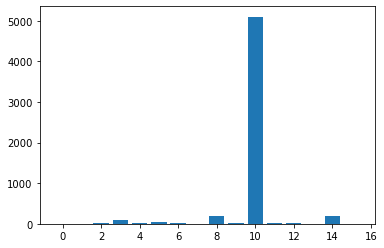

In [337]:
# 用户消费偏好统计
def book_check(x):
    dic = {}
    for i in x:
        if i in dic.keys():
            dic[i] += 1
        else:
            dic[i] = 1
    return dic

# 单个用户消费偏好统计
user_preference = df_cs.groupby(['用户编号'])['图书类型'].apply(lambda x:book_check(x))
user_preference.dropna(inplace =True)
user_preference.sort_values(ascending=False)

user_preference.to_excel('用户购买偏好.xlsx')

# 平台用户消费偏好统计
users_preference = df_cs.groupby(['图书类型'])['图书类型'].apply(lambda x:book_check(x))
users_preference.dropna(inplace =True)
users_preference.sort_values(ascending=False)

categories=[i[0] for i in users_preference.keys()]  # 取列表标签作为x轴 

data2 = list(users_preference)

plt.bar(x,data2)  # 平台销量最高的商品

users_preference.to_excel('平台销售情况.xlsx')

In [273]:
# 用户用券情况分析
df_coupon = pd.read_excel('消费数据.xlsx',sheet_name='优惠券使用情况')
df_coupon.groupby('收货人手机号')['领券手机号'].count() # 大于单个用户可得券总数的可以判断为异常用户

,index,标签,M,R,F
0,0,0,431.577826,7.688406,8.942029
1,1,1,197.011111,148.246914,2.827160
2,2,2,3005.981667,23.541667,34.500000
3,3,3,21370.300000,1.000000,151.000000
4,4,4,10699.705833,6.833333,102.416667
5,5,5,275.567740,43.062147,4.519774
6,6,6,361.551154,107.064103,5.666667
7,7,7,5262.029091,11.636364,75.818182


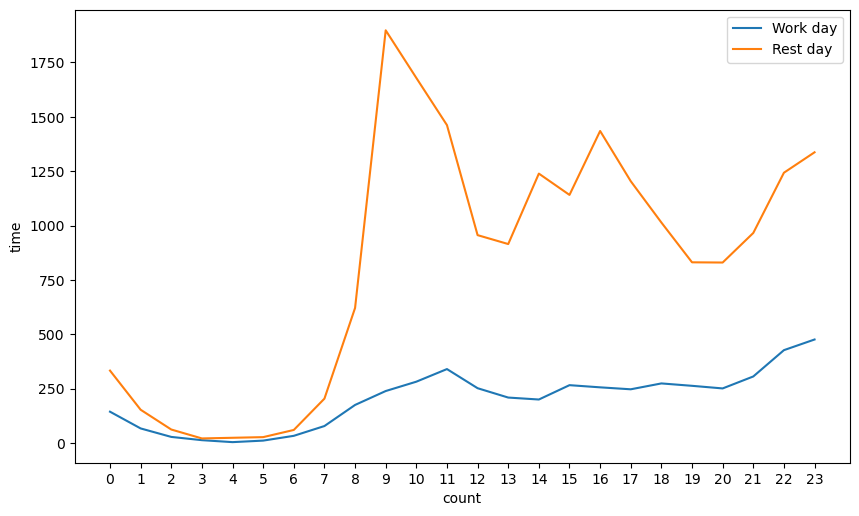

In [401]:
# 用户发帖,购物习惯
df_post_time = df_post.loc[:,['发布时间','UID']]
df_post_time['发布时间'] = pd.to_datetime(df_post_time['发布时间'])
df_post_time['小时'] = df_post_time['发布时间'].dt.hour
df_post_time['工作日'] = df_post_time['发布时间'].dt.weekday+1
df_post_time.columns

df_post_time['工作日'] = df_post_time.apply(lambda x:1 if x['工作日'] < 6 else 0,axis = 1)
df_post_time_total = df_post_time.groupby(['工作日','小时'])['UID'].count()

time = range(24)
x1 = list(df_post_time_total[0])  # 休息日发布情况
x2 = list(df_post_time_total[1])  # 工作日发布情况

fig = plt.figure(figsize=(10,6), dpi=100)
plt.plot(time, x1, label='Work day')
plt.plot(time, x2, label='Rest day')
plt.xticks(time)

plt.legend()
plt.xlabel('count')
plt.ylabel('time')

plt.show()

标签
0    138
1     81
2     24
3      1
4     12
5    177
6     78
7     11
Name: 收货手机号, dtype: int64